In [1]:
import os

# 限制 OpenMP 使用的核心数
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["OPENBLAS_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"

import os
import numpy as np
np.random.seed(49)
import pandas as pd

from helper_simulation import *
from helper_util import *
from comparison import ComparisonGong, ComparisonBodik

from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite.independence_tests import ParCorr
from tigramite import plotting as tp



from rpy2.robjects.conversion import localconverter


from scipy.stats import t as t_distribution
from rpy2.robjects.conversion import localconverter
import matplotlib.pyplot as plt

%matplotlib inline



max_id=get_max("exp_result")
exp_str=""
log_path=f"exp_result/{str(max_id)}.simulationComparison"

logger=get_logger(log_path)


/home/jianj0c/anaconda3/envs/py3-env/lib/python3.7/site-packages/tigramite/independence_tests/gpdc.py:16: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/home/jianj0c/anaconda3/envs/py3-env/lib/python3.7/site-packages/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'dcor'
  warnings.warn(str(e))


exp_result/29.simulationComparison/xx.log


In [2]:
num_nodes = 13  # number of nodes
n=5000 # number of samples
sparsity=0.1
quantile=1 
pc_alpha=0.005

adjacency_matrix,edges_matrix = generate_dag(num_nodes,edge_probability=sparsity)

## This block generates a Directed Acyclic Graph (DAG) and simulates data based on it. Then, it performs causal inference on the generated data using two different methods (the method from this paper and Gong's method) and compares the error rates of the inferred results with the true graph. Finally, it plots the true graph and the inferred results from both methods.



In [3]:


pathh=os.path.join(log_path,f"NodeSize:{num_nodes},EdgeSize:{(adjacency_matrix>0).sum()}.pdf")


IC_1=np.linalg.inv(np.eye(adjacency_matrix.shape[0])-adjacency_matrix)

R[write to console]: 
Attaching package: ‘spectralGraphTopology’


R[write to console]: The following object is masked from ‘package:stats’:

    D


R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union


R[write to console]: 
Attaching package: ‘evd’


R[write to console]: The following object is masked from ‘package:igraph’:

    clusters




the ground truth graph is:


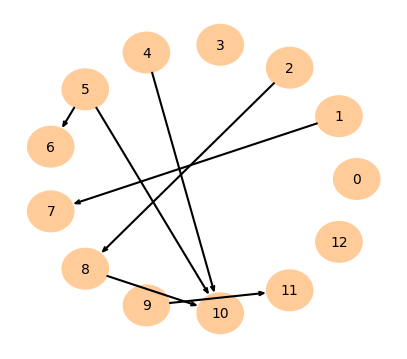

the results of this paper is: (with error rate: 0.0%)


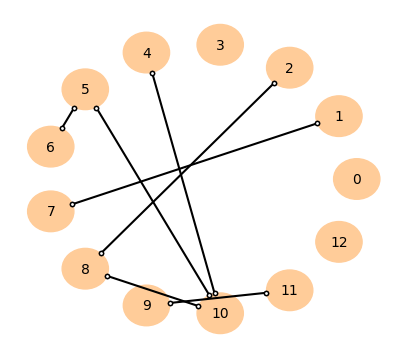

the results of Gong is: (with error rate: 27.3%)


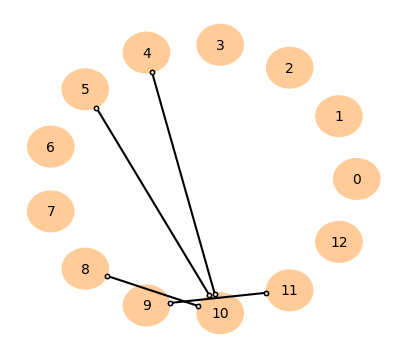

In [4]:




pathh=os.path.join(log_path,f"NodeSize:{num_nodes},EdgeSize:{(adjacency_matrix>0).sum()}.pdf")


IC_1=np.linalg.inv(np.eye(adjacency_matrix.shape[0])-adjacency_matrix)
N_data=simulation(n,num_nodes).T
X_data=otimes(IC_1,N_data,False)
data_df=pd.DataFrame(X_data.T)


resultsThisPaper,_=method_this_paper(data_df,pc_alpha=pc_alpha,quantile=quantile)
resultsGong=ComparisonGong(data_df,alpha = 0.04, beta = 1.26)

error_rate_this_paper,_=compare_graphs(resultsThisPaper,edges_matrix)
error_rate_gong,_=compare_graphs(resultsGong,edges_matrix)
print("the ground truth graph is:")
draw_graph(edges_matrix)
print("the results of this paper is: (with error rate: {:.1f}%)".format(error_rate_this_paper*100))
draw_graph(resultsThisPaper)
print("the results of Gong is: (with error rate: {:.1f}%)".format(error_rate_gong*100))
draw_graph(resultsGong)

## have a lot of scatter plot


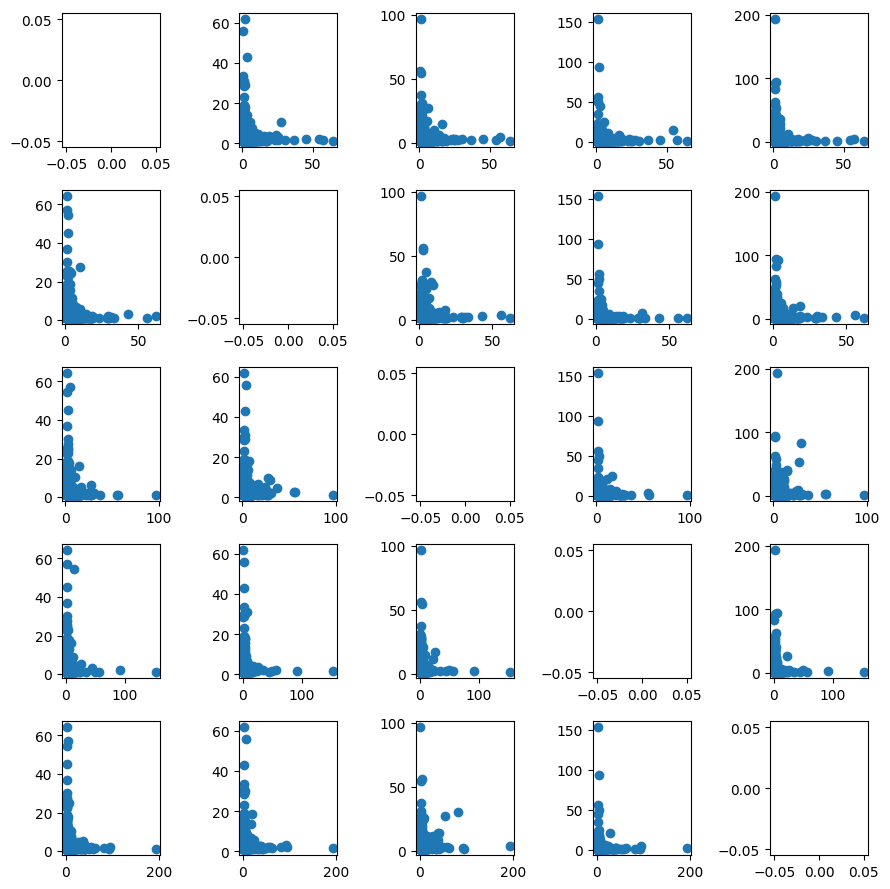

In [5]:
import matplotlib.pyplot as plt

num_vars = 5#data_df.shape[1]
fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=(9, 9))

for i in range(num_vars):
    for j in range(num_vars):
        if i != j:
            axes[i, j].scatter(data_df.iloc[:, i], data_df.iloc[:, j])
        else:
            axes[i, j].scatter([],[])

plt.tight_layout()
plt.show()

## both tail scenario


## two tails simulation

$$
A =
\begin{bmatrix}
\alpha^+_1 & \cdots & 0 \\
\vdots  & \ddots & \vdots \\
0 &  \cdots & \alpha^+_p \\
\alpha^-_1 & \cdots & 0 \\
\vdots  & \ddots & \vdots \\
0 &  \cdots & \alpha^-_p 
\end{bmatrix}, \quad A \in \mathbb{R}_+^{2p \times p}
$$

$$
K = \rm{diag}(K_1, \cdots, K_p, 1-K_1, \cdots, 1-K_p), \quad K \in \{0,1\}^{2p \times 2p}
$$


The data is generated by:
$$\bm{\bar{X}}=((\bm{I}-KB)^{-1}KA)\circ \bm{N}$$

In [29]:
pc_alpha=0.005
sparsity=0.21
quantile=0.1
N=5000
num_nodes = 5 # 图中的节点数


adjacency_matrix,edge_shape = generate_dag_two_tails(num_nodes,edge_probability=sparsity)
B=adjacency_matrix
A=np.diag(np.ones(num_nodes))
A=np.concatenate([A,A],axis=0)
switch_probability=np.ones(num_nodes)*0.5

N_data=simulation(N,num_nodes).T
K_data=(np.random.uniform(0,1,size=(N,num_nodes))>0.5).astype(int)
K_data_=np.concatenate([K_data,1-K_data],axis=1)

K_data=np.array([np.diag(k) for k in K_data_])


# 代码实现
I = np.diag(np.ones(num_nodes * 2))
KA = K_data @ A
KB = K_data @ B
IKB_inv=np.linalg.inv(I-KB)
X_data_bar=otimes(IKB_inv @ KA,N_data,False)
X_data_bar_=transform_softplus(X_data_bar,True)
X_data=X_data_bar_[:num_nodes,:]-X_data_bar_[num_nodes:,:]


# the scatter plot of the data

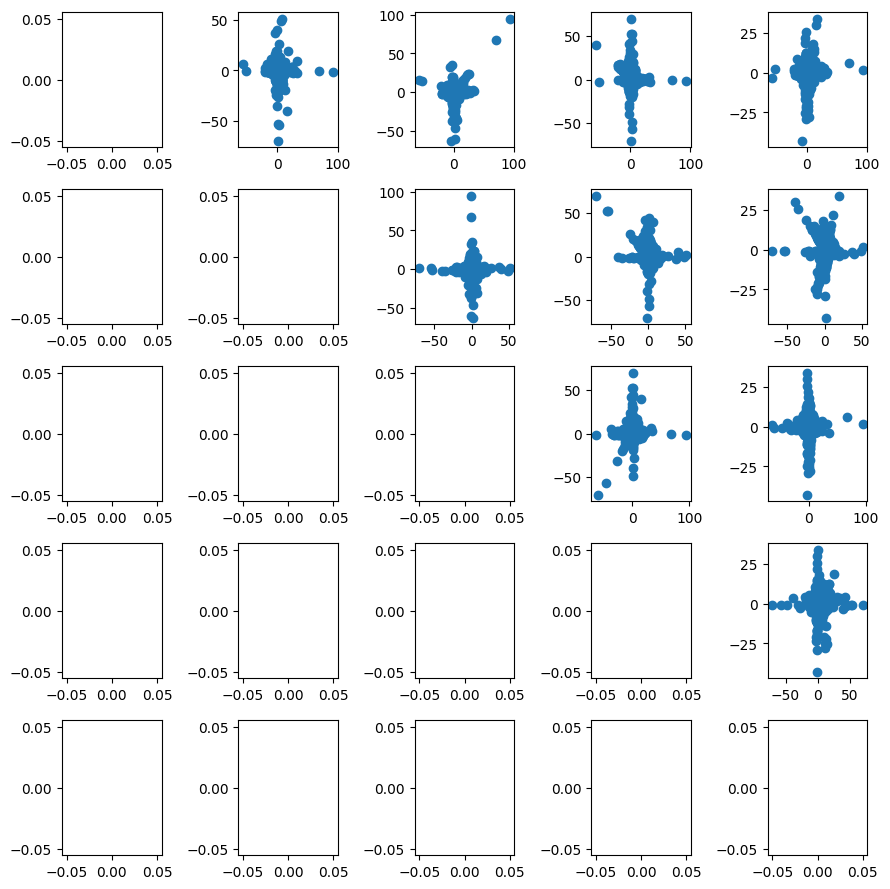

the ground truth graph is:


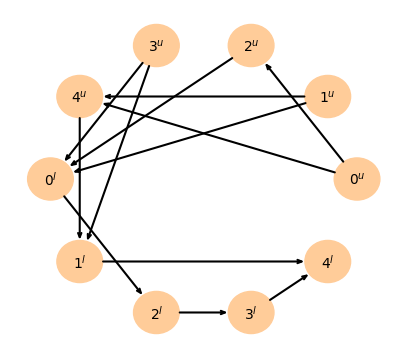

In [30]:
import matplotlib.pyplot as plt
data_df=pd.DataFrame(X_data.T)
num_vars = data_df.shape[1]
fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=(9, 9))

for i in range(num_vars):
    for j in range(num_vars):
        if i <j:
            axes[i, j].scatter(data_df.iloc[:, i], data_df.iloc[:, j])
        else:
            axes[i, j].scatter([],[])

plt.tight_layout()
plt.show()

print("the ground truth graph is:")
draw_graph(edge_shape,var_names=[f"${i}^{{u}}$" for i in range(num_nodes)]+[f"${i}^{{l}}$" for i in range(num_nodes)])

In [31]:
data_df_bar=pd.DataFrame(X_data_bar.T)
resultsThisPaper,_=method_this_paper(data_df_bar,both_tail=True,nodes_number=num_nodes,pc_alpha=0.005,quantile=1)



the results of this paper is: (with error rate: 20.0%)


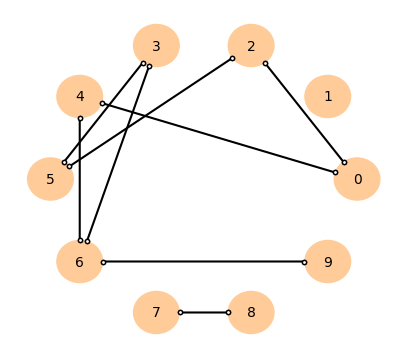

In [32]:



error_rate_this_paper,_=compare_graphs(resultsThisPaper,edge_shape)

print("the results of this paper is: (with error rate: {:.1f}%)".format(error_rate_this_paper*100))
draw_graph(resultsThisPaper)


## The TPDM for $\bar{\bm{X}}$





